# Registration of Sentinel-2 with NAIP 2019

### Import Packages

In [1]:
# Import packages

from pathlib import Path
from arosics import COREG, COREG_LOCAL, DESHIFTER
from geoarray import GeoArray
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os

### Path Setup

In [2]:
# Set the working directory

wd = Path('/media/antonio/antonio_ssd/FORCE/corregistration')
#wd = Path('F:/FORCE/corregistration')
assert wd.exists()

### Load the Reference Image

In [5]:
# Select and read title of intest from NAIP

basemap_file = wd/'X0014_Y0024/NAIP_X0014_Y0024.tif' #This is the NAIP scene of 2019 for the title of interest
reference = GeoArray(str(basemap_file))

# Plot raster
# reference.show(figsize = (15, 15))

### Load Target Image

Note: array has been downsampled to 1000 x 1000 for faster visualization.


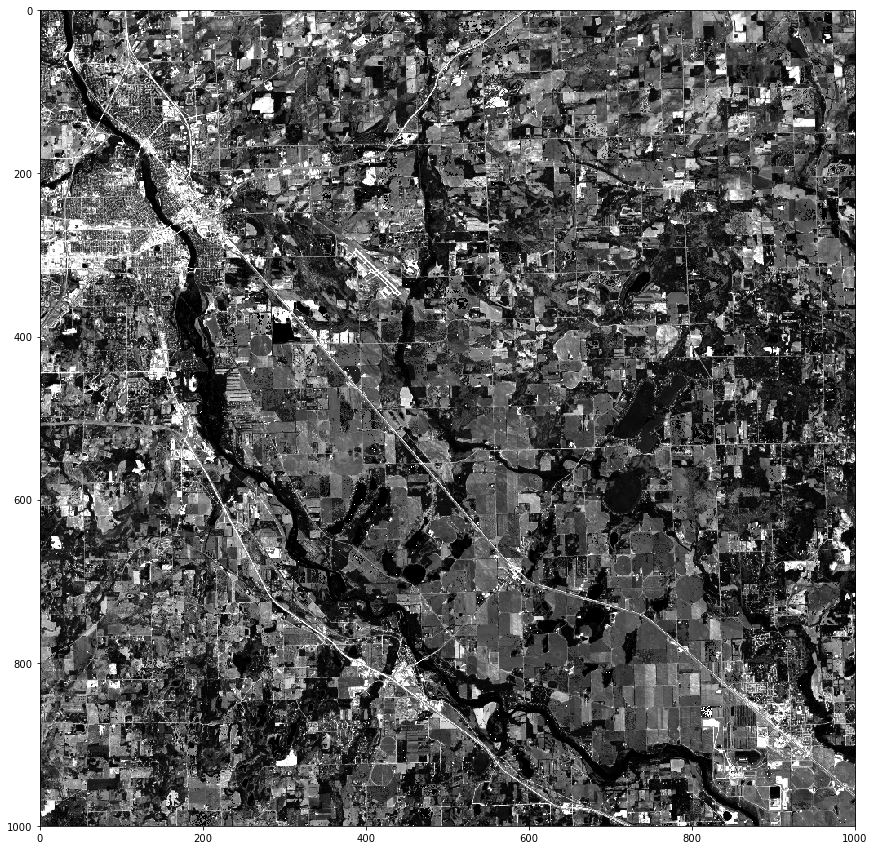

In [6]:
# Select and the image/title of interest from Sentinel-2

target_file = wd/'X0014_Y0024/X0014_Y0024_red.tif' #This is the average RED band for the groing period of 2019
target = GeoArray(str(target_file))

# Plot raster
target.show(figsize = (15, 15))

### Coregistration to a Basemap Image

In [7]:
# Sometimes the projections does not match. Let's force them to be the same regardless if they are equal.
if reference.projection == target.projection:
    reference.projection = target.projection
else:
    print("Stop, you need to check the projection to continue")    

In [8]:
# Setup parameters for tiepoint detection and affine transformation factor calculation
coreg_kwargs = {
    'grid_res': 100, # Tie point spacing in x-direction, in terms of target image pixels
    'window_size': (164, 164), # Size of matching window
    'nodata': (0.0, -9999), # No-data values for reference & target images
    'max_iter': 8,
    'r_b4match': 3, # Reference band for matching
    's_b4match': 1, # Target band for matching
    'CPUs': 24,      # For Ubuntu only
    'max_shift': 150,
    'min_reliability': 20
}

# Apply local image coregistration
CRL = COREG_LOCAL(reference, target, **coreg_kwargs)

# Inspect the result
CRL.correct_shifts()

/home/antonio/.local/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Calculating footprint polygon and actual data corner coordinates for reference image...


Polygonize progress     |==================================================| 99.0% Complete  => 0:00:14

KeyboardInterrupt: 

/home/antonio/.local/lib/python3.8/site-packages/geoarray/baseclasses.py:737: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Bounding box of calculated footprint for reference image:
	(141513.544, 707092.4671, 166559.6685, 735430.0865)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(139292.51690292917, 705980.1870542851, 169292.51690292917, 735980.1870542851)
Matching window position (X,Y): 154036.60625/721261.2768


/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)


Initializing tie points grid...
Equalizing pixel grids and projections of reference and target image...


Warping progress     |==================================================| 100.0% Complete  => 0:01:44
Warping progress     |==================================================| 100.0% Complete  => 0:00:02


Calculating tie point grid (700 points) using 24 CPU cores...


	progress: |==------------------------------------------------| 3.1% Complete  => 0:00:00/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
	progress: |==------------------------------------------------| 3.9% Complete  => 0:00:00/home/antonio/.local/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:217: RuntimeWarning: invalid value encountered in subtract
  vx = co

/home/antonio/.local/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:217: RuntimeWarning: invalid value encountered in subtract
  vx = cov_norm * (uxx - ux * ux)
/home/antonio/.local/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:219: RuntimeWarning: invalid value encountered in subtract
  vxy = cov_norm * (uxy - ux * uy)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:217: RuntimeWarning: invalid value encountered in subtract
  vx = cov_norm * (uxx - ux * ux)
/home/antonio/.local/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:219: RuntimeWarning: invalid value encountered in subtract
  vxy = cov_norm * (uxy - ux * uy)
/home/antonio/.local/lib/python3.8/site-p

/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in multiply
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in multiply
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
	progress: |=============-------------------------------------| 26.6% Complete  => 0:00:00/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/l

/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in multiply
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered 

	progress: |=======================---------------------------| 46.4% Complete  => 0:00:01/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in multiply
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in multiply
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/l

/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in

/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in

/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in

/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
	progress: |==========================================--------| 83.4% Complete  => 0:00:02/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/p

/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in

/home/antonio/.local/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:219: RuntimeWarning: invalid value encountered in subtract
  vxy = cov_norm * (uxy - ux * uy)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in multiply
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in multiply
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1182: RuntimeWarning: invalid value encountered in divide
  temp = np.array(fft_ar

Found 369 matches.
Performing validity checks...
7 tie points flagged by level 1 filtering (reliability).
85 tie points flagged by level 2 filtering (SSIM).


/home/antonio/.local/lib/python3.8/site-packages/arosics/DeShifter.py:291: UserWarning: 
The coordinate grid of X0014_Y0024_red cannot be aligned to the desired grid because their pixel sizes are not exact multiples of each other (input [X/Y]: 10.0/10.0; desired [X/Y]: 0.41247199531062506/0.42932534508872777). Therefore the original grid is chosen for the resampled output image. If you don´t like that you can use the 'out_gsd' or 'match_gsd' parameters to set an appropriate output pixel size or to allow changing the pixel size.

  warnings.warn("\nThe coordinate grid of %s cannot be aligned to the desired grid because their pixel "
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |=========================-------------------------| 50.0% Complete  => 0:00:00

22 tie points flagged by level 3 filtering (RANSAC)
262 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00


OrderedDict([('band', None),
             ('is shifted', True),
             ('is resampled', True),
             ('updated map info',
              ['lcc',
               1.0,
               1.0,
               139292.51690292917,
               735980.1870542851,
               10.0,
               10.0,
               'NAD83']),
             ('updated geotransform',
              (139292.51690292917, 10.0, 0.0, 735980.1870542851, 0.0, -10.0)),
             ('updated projection',
              'PROJCS["USA_Contiguous_Lambert_Conformal_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",39],PARAMETER["central_meridian",-96],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["fal

In [9]:
with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'): # Ignore AROSICS complaining
    result = CRL.correct_shifts()

/home/antonio/.local/lib/python3.8/site-packages/arosics/DeShifter.py:291: UserWarning: 
The coordinate grid of X0014_Y0024_red cannot be aligned to the desired grid because their pixel sizes are not exact multiples of each other (input [X/Y]: 10.0/10.0; desired [X/Y]: 0.41247199531062506/0.42932534508872777). Therefore the original grid is chosen for the resampled output image. If you don´t like that you can use the 'out_gsd' or 'match_gsd' parameters to set an appropriate output pixel size or to allow changing the pixel size.

  warnings.warn("\nThe coordinate grid of %s cannot be aligned to the desired grid because their pixel "
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Correcting geometric shifts...


Note: array has been downsampled to 1000 x 1000 for faster visualization.


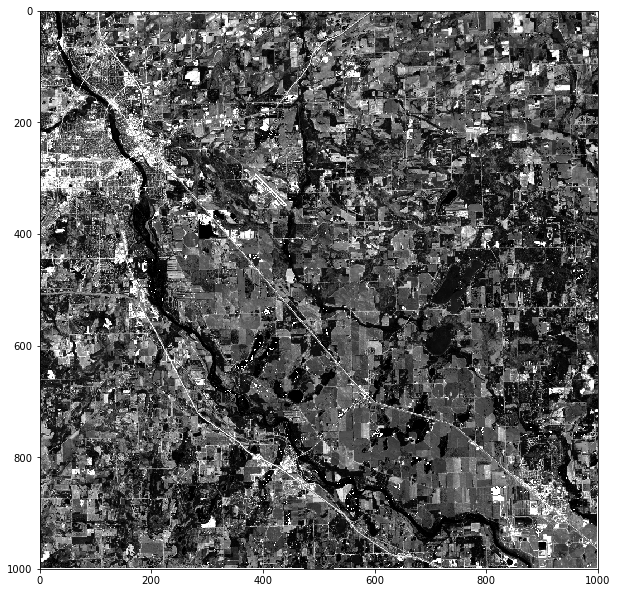

/home/antonio/.local/lib/python3.8/site-packages/py_tools_ds/geo/projection.py:169: RuntimeWarning: Could not find a suitable EPSG code for the input WKT string.
  warnings.warn('Could not find a suitable EPSG code for the input WKT string.', RuntimeWarning)


Note: array has been downsampled to 1000 x 1000 for faster visualization.


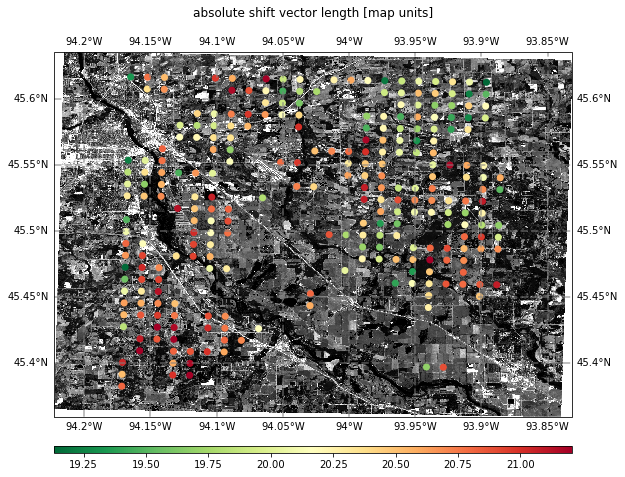

In [10]:
# Show the corrected target image geoarray
result['GeoArray_shifted'].show(figsize = (10, 15))

# Show tie points on top of the target image
CRL.view_CoRegPoints()

In [11]:
# Show the points table of the calculated tie point grid
# Notes: Point records where no valid match has been found are filled with -9999.0
# False-positive "labeled as False" points are not used to compute transformation factors
CRL.CoRegPoints_table

,geometry,POINT_ID,X_IM,Y_IM,X_MAP,Y_MAP,REF_BADDATA,TGT_BADDATA,X_WIN_SIZE,Y_WIN_SIZE,...,ANGLE,SSIM_BEFORE,SSIM_AFTER,SSIM_IMPROVED,RELIABILITY,LAST_ERR,L1_OUTLIER,L2_OUTLIER,L3_OUTLIER,OUTLIER
0,POINT (142292.517 734980.187),34,300,100,142292.516903,734980.187054,False,False,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,Matching window in target image is larger than...,-9999,-9999,-9999,-9999
1,POINT (143292.517 734980.187),35,400,100,143292.516903,734980.187054,False,False,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,Matching window in target image is larger than...,-9999,-9999,-9999,-9999
2,POINT (144292.517 734980.187),36,500,100,144292.516903,734980.187054,False,False,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,Matching window in target image is larger than...,-9999,-9999,-9999,-9999
3,POINT (145292.517 734980.187),37,600,100,145292.516903,734980.187054,False,False,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,Matching window in target image is larger than...,-9999,-9999,-9999,-9999
4,POINT (146292.517 734980.187),38,700,100,146292.516903,734980.187054,False,False,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,Matching window in target image is larger than...,-9999,-9999,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,POINT (162292.517 707980.187),891,2300,2800,162292.516903,707980.187054,False,False,164.0,164.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,No match found in the given window.,-9999,-9999,-9999,-9999
696,POINT (163292.517 707980.187),892,2400,2800,163292.516903,707980.187054,False,False,164.0,164.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,No match found in the given window.,-9999,-9999,-9999,-9999
697,POINT (164292.517 707980.187),893,2500,2800,164292.516903,707980.187054,False,False,164.0,164.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,No match found in the given window.,-9999,-9999,-9999,-9999
698,POINT (165292.517 707980.187),894,2600,2800,165292.516903,707980.187054,False,False,164.0,164.0,...,-9999.0,-9999.0,-9999.0,-9999,-9999.0,No match found in the given window.,-9999,-9999,-9999,-9999


In [12]:
# Export tie point grid to an ESRI point shapefile
tiepoint_file = wd/('X0014_Y0024/tiepoint')

CRL.tiepoint_grid.to_PointShapefile(path_out = tiepoint_file)

Writing /media/antonio/antonio_ssd/FORCE/corregistration/X0014_Y0024/tiepoint ...


/home/antonio/.local/lib/python3.8/site-packages/arosics/Tie_Point_Grid.py:888: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  GDF2pass.to_file(path_out)


### Applying Calculated Shifts

In [13]:
# Apply previously-calculated shifts to the full-band image
deshifter = DESHIFTER(target, CRL.coreg_info)

# Warp the full-band image "with the cubic convolution resampling"
target_shifted_all_bands = deshifter.correct_shifts()

# Get shifted GeoArray
target_geoarray_shifted_all_bands = target_shifted_all_bands['GeoArray_shifted']

# Set file path to shifted image
target_file_shifted_all_bands = wd/('X0014_Y0024/tiepoint/corg_Sentinel2_X0014_Y0024.tif')

# Save the shifted image into GTiff, use this image for manual assessment.
target_geoarray_shifted_all_bands.save(str(target_file_shifted_all_bands),
                                       fmt = 'GTiff')

Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Correcting geometric shifts...
Writing GeoArray of size (3000, 3000) to /media/antonio/antonio_ssd/FORCE/corregistration/X0014_Y0024/tiepoint/corg_Sentinel2_X0014_Y0024.tif.


### Apply shifts in a batch

In [15]:
# If the corrections works you can apply it in a batch.
# Select input path
in_wd = Path('/media/antonio/antonio_ssd/FORCE/level3/X0014_Y0024')

# Select output path
out_wd = Path('/media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024')

# List images to transform 
files = os.listdir(in_wd)
files

['2017-2021_001-365_HL_TSA_SEN2L_CCI_TSI.tif',
 '2017-2021_001-365_HL_TSA_SEN2L_CCI_TSS.tif',
 '2017-2021_001-365_HL_TSA_SEN2L_CRE_TSI.tif',
 '2017-2021_001-365_HL_TSA_SEN2L_CRE_TSS.tif',
 '2017-2021_001-365_HL_TSA_SEN2L_KNV_TSI.tif',
 '2017-2021_001-365_HL_TSA_SEN2L_KNV_TSS.tif',
 '2017-2021_001-365_HL_TSA_SEN2L_NDW_TSI.tif',
 '2017-2021_001-365_HL_TSA_SEN2L_NDW_TSS.tif']

In [16]:
# Apply correctiton in batch

for file in files:
    int_file = in_wd/file
    out_file = out_wd/file
        
    scene = GeoArray(str(int_file))
    reference.projection = scene.projection

    # Apply shifts
    deshifter = DESHIFTER(scene, CRL.coreg_info, resamp_alg = 'nearest')

    # Warp the full-band image "with the nearest resampling"
    target_shifted_all_bands = deshifter.correct_shifts()

    # Get shifted GeoArray
    target_geoarray_shifted_all_bands = target_shifted_all_bands['GeoArray_shifted']

    # Save the shifted image into ENVI *.hdr format with metada
    target_geoarray_shifted_all_bands.save(str(out_file), fmt = 'GTiff')

Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:06


Writing GeoArray of size (3000, 3000, 114) to /media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024/2017-2021_001-365_HL_TSA_SEN2L_CCI_TSI.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:03


Writing GeoArray of size (3000, 3000, 87) to /media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024/2017-2021_001-365_HL_TSA_SEN2L_CCI_TSS.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:06


Writing GeoArray of size (3000, 3000, 114) to /media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024/2017-2021_001-365_HL_TSA_SEN2L_CRE_TSI.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:03


Writing GeoArray of size (3000, 3000, 87) to /media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024/2017-2021_001-365_HL_TSA_SEN2L_CRE_TSS.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:06


Writing GeoArray of size (3000, 3000, 114) to /media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024/2017-2021_001-365_HL_TSA_SEN2L_KNV_TSI.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:03


Writing GeoArray of size (3000, 3000, 87) to /media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024/2017-2021_001-365_HL_TSA_SEN2L_KNV_TSS.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:06


Writing GeoArray of size (3000, 3000, 114) to /media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024/2017-2021_001-365_HL_TSA_SEN2L_NDW_TSI.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:03


Writing GeoArray of size (3000, 3000, 87) to /media/antonio/antonio_ssd/FORCE/level3_shifted/X0014_Y0024/2017-2021_001-365_HL_TSA_SEN2L_NDW_TSS.tif.
